## Short guide on using Jax and diffrax in QuTiP
neill lambert  https://github.com/nwlambert/QuTiP-Jax-GPU-example

With the new Jax data layer using Jax and GPU acceleration in QuTiP is now feasible. In this
notebook we will explain the steps to get this to work, including installation.

Note that these steps we performed using Windows Subsystems for Linux v2 on windows 11.
Your milage may vary with the CUDA steps on other platforms!

Firstly, follow the installation guide for QuTiP v5 at www.qutip.org with 
'pip install qutip'

Then install qutip-jax data layer with
'pip install git+https://github.com/qutip/qutip-jax.git'

For more infromation on the data layer see https://qutip-jax.readthedocs.io/en/latest/index.html
and the notebook https://github.com/qutip/qutip-tutorials/blob/main/tutorials-v5/miscellaneous/JAX_backend.md

To actually use the GPU mode in jax you will need to install the correct Jax CUDA version:

'pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html'

This is a point where you might have issues!

Next, lets try importing everything and see if it works...

In [11]:
import time
import qutip as qt
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import qutip_jax
import jax
from diffrax import diffeqsolve, ODETerm, Dopri5, PIDController, ConstantStepSize,  Tsit5

#pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

To demonstrate how to use mesolve or sesolve with jax and a gpu we construct a simple 1D ising model example. 
This allows us to check run time as a function of system size

In [2]:

def Ising_solve(N, g0, J0, gamma, tlist, options, data_type = 'csr'):
    #N: number of spins
    #g0: energy splitting
    #J0: nearest neighbour coupling
    #gamma: single decay rate
    #tlist: list of time steps
    #options: ode options
    #data_type: string for data type to use

    # Setup operators for individual qubits  

    g = g0 * np.ones(N) # Energy splitting term
    J = J0 * np.ones(N) # Interaction coefficients
    sx_list, sy_list, sz_list = [], [], []

    for i in range(N):
        op_list = [qt.qeye(2)] * N
        op_list[i] = qt.sigmax().to(data_type) 
        sx_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmay().to(data_type) 
        sy_list.append(qt.tensor(op_list))
        op_list[i] = qt.sigmaz().to(data_type) 
        sz_list.append(qt.tensor(op_list))
 


    # Hamiltonian - Energy splitting terms
    H = 0.
    for i in range(N):
        H += g[i] * sz_list[i]

    # Interaction terms
    for n in range(N - 1):
        H += -J[n] * sx_list[n] * sx_list[n + 1]

    #dissipation (just on final spin)
    if gamma>0.:
        if data_type == 'jaxdia':
            c_ops = [jnp.sqrt(gamma) * sx_list[N-1]]  
        else:
            c_ops = [np.sqrt(gamma) * sx_list[N-1]]  
    else:
        c_ops = []

    state_list = [qt.basis(2, 0)] * (N)
    psi0 = qt.tensor(state_list)
    H.isherm
    sz_list[-1].isherm
    e_ops = [sz_list[-1]]
    result = qt.mesolve(H,psi0, tlist, c_ops, e_ops=e_ops, options=options)

    return result, result.e_data[0]


First lets run this for default QuTiP, without dissipation, for a single choice of number of spins $N=17$

In [3]:
 
#default qutip
run_time_list_cpu_sesolve_qutip = []
results_list_cpu_sesolve_qutip = []

g0 = 1
J0 = 1.4
gamma = 0.
tlist = np.linspace(0,50,100)

options = {"normalize_output": False, "atol": 1e-6, "rtol": 1e-6, "progress_bar":""} 

N_list = [17] #just a single data point here, to save time

for N in N_list:
    print("N=", N)
    result_cpu, sz = Ising_solve(N,  g0, J0, gamma, tlist, options)
    run_time_list_cpu_sesolve_qutip.append(result_cpu.stats['run time'])
    results_list_cpu_sesolve_qutip.append(sz)
          
            


N= 17


to do the same with Jax data layer and using the GPU we take advantage of two useful 'with' statements, one sets most objects in qutip to use the 
'jaxdia' data format, and the other tells Jax to use the GPU device (to run on CPU instead, one can just replace gpu with cpu).

With sesolve or mesolve we have to use the method = 'diffrax'.  This takes options similar to standard methods.

One point; we could also use the Jax dense data format here, but the custom Dia sparse format available in qutip allows us to go to much larger system sizes, 
where the advantage of using a GPU to solve ODES becomes apparent.


In [4]:

run_time_list_gpu_sesolve_jaxdia = []
results_list_gpu_sesolve_jaxdia = []
#Jaxdia version

with jax.default_device(jax.devices("gpu")[0]):
    with qt.CoreOptions(default_dtype="jaxdia"):

        g0 = 1
        J0 = 1.4
        gamma = 0.
        
        tlist = np.linspace(0,50,100)
        options = {"method": "diffrax", "normalize_output": False, "stepsize_controller" : PIDController(rtol=1e-6, atol=1e-6), "solver": Tsit5(), "progress_bar":""}
        N_list = [17]
        run_time_list_gpu = []
        for N in N_list:
            result_gpu, sz = Ising_solve(N,  g0, J0, gamma, tlist, options, data_type = 'jaxdia')
            
            run_time_list_gpu_sesolve_jaxdia.append(result_gpu.stats['run time'])
            results_list_gpu_sesolve_jaxdia.append(sz)
          
            


/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


Next we do a case with dissipation, slightly smaller system size $N=9$

In [5]:
 
#default qutip, with disspation (mesolve)
run_time_list_cpu_mesolve_qutip = []
results_list_cpu_mesolve_qutip = []


g0 = 1
J0 = 1.4
gamma = 0.1
tlist = np.linspace(0,50,100)

options = {"normalize_output": False, "atol": 1e-6, "rtol": 1e-6, "progress_bar":""} 

N_list = [9]
for N in N_list:
    print("N=", N)
    result_cpu, sz = Ising_solve(N,  g0, J0, gamma, tlist, options)
    run_time_list_cpu_mesolve_qutip.append(result_cpu.stats['run time'])
    results_list_cpu_mesolve_qutip.append(sz)
          
            



N= 9


In [6]:
 

run_time_list_gpu_mesolve_jaxdia = []
results_list_gpu_mesolve_jaxdia = []
#Jaxdia version

with jax.default_device(jax.devices("gpu")[0]):
    with qt.CoreOptions(default_dtype="jaxdia"):

        g0 = 1
        J0 = 1.4
        gamma = 0.1
        tlist = np.linspace(0,50,100)

        options = {"method": "diffrax", "normalize_output": False, "stepsize_controller" : PIDController(rtol=1e-6, atol=1e-6), "solver": Tsit5(), "progress_bar":""}

        N_list = [9]
        run_time_list_gpu = []
        for N in N_list:
            result_gpu, sz  = Ising_solve(N,  g0, J0, gamma, tlist, options, data_type = 'jaxdia')
            
            run_time_list_gpu_mesolve_jaxdia.append(result_gpu.stats['run time'])
            results_list_gpu_mesolve_jaxdia.append(sz)
          
            


/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)


Lets compare the run times. These are the times reported by the solver itself, and don't include setup.  For smaller system sizes (not shown here) normal qutip will
outperform jax+diffrax.  For large sizes we see substantial benefit with jax+diffrax.

In [13]:

print("cpu sesolve:", run_time_list_cpu_sesolve_qutip)
print("gpu sesolve:", run_time_list_gpu_sesolve_jaxdia)

cpu sesolve: [81.47192883491516]
gpu sesolve: [21.430046319961548]


In [14]:
print("cpu mesolve:",run_time_list_cpu_mesolve_qutip)
print("gpu mesolve:",run_time_list_gpu_mesolve_jaxdia)

cpu mesolve: [173.7914116382599]
gpu mesolve: [50.78608584403992]


Note that you will be limited on system size by the GPU memory you have available.



Another nice feature of Jax is auto differentiation. For example, by wrapping the example above in 
a function which just returns an expectation value, we can then find gradients of that observable as 
a function of various parameters    

In [9]:

energy_list =[]
with jax.default_device(jax.devices("gpu")[0]):
    with qt.CoreOptions(default_dtype="jaxdia"):
        def wrap(tlist,J0):
            g0 = 1
            gamma = 0.1
            options = {"method": "diffrax", "normalize_output": False, "stepsize_controller" : PIDController(rtol=1e-6, atol=1e-6), "solver": Tsit5(), "progress_bar":""}

            N = 4
            
            result_gpu, sz  = Ising_solve(N,  g0, J0, gamma, tlist, options, data_type = 'jaxdia')
            return sz
        
        tlist = jnp.linspace(0,5,100)
        J0 = 1.4
        grad_t_func = jax.jacrev(wrap,argnums=0)
        grad_J0_func = jax.jacrev(wrap,argnums=1)
        
        val = wrap(tlist, J0)
        grad_t = grad_t_func(tlist, J0)
        grad_J0 = grad_J0_func(tlist, J0)
        

        
          
            


/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
  out = fun(*args, **kwargs)
/home/neill/anaconda3/envs/qutip5pip/lib/python3.12/site-packages/equinox/_jit.py:49: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
 

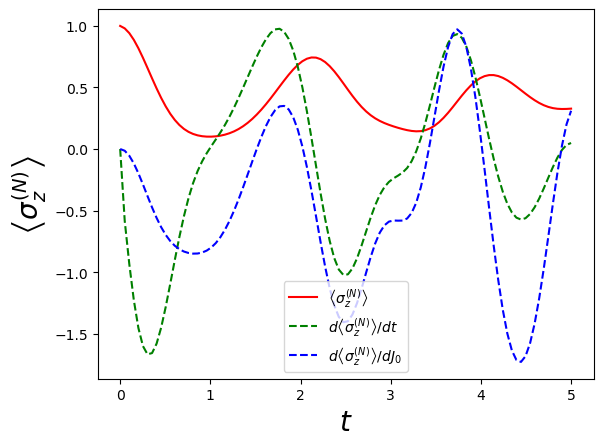

In [12]:

#extract diaganals;
grad_tlist_list_diags = [grad_t[i][i] for i in range(100)]

fig, axes = plt.subplots(1, 1)
axes.plot(tlist, val,'r',label =r"$\left< \sigma_z^{(N)} \right>$" )
axes.plot(tlist, grad_tlist_list_diags,'g--',label=r"$d \left<\sigma_z^{(N)}\right>/dt$")
axes.plot(tlist, grad_J0,'b--',label=r"$d \left<\sigma_z^{(N)}\right>/dJ_0$")

axes.set_xlabel(r"$t$", fontsize=20)
axes.set_ylabel(r"$\left< \sigma_z^{(N)} \right>$", fontsize=20);
axes.legend()

We can take gradients of any parameter by modifying the above code.

Caveats; 
If you need higher order derivates, the second and higher must be done with jacfwd().
what can and cant be autogradded and Jit'd is a little tricky sometimes.  Some guidelines are provided here
https://github.com/qutip/qutip-tutorials/blob/main/tutorials-v5/miscellaneous/JAX_backend.md





Other ways to take advantage of jax+gpu:

Jax can be used to Jit functions, typically providing a big benefit if they are run multiple times

Jax supports vmap, akin to numps vectorization, which allows for easy parralization of functions with vector inputs/outputs
https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html

We are still exploring how it can assist in speeding up other solvers, particulary those relying on linear-solve functions, like steadystate.
